# Martian SDK Quickstart Guide

In [ ]:
!git clone https://github.com/withmartian/martian-sdk-python.git

Cloning into 'martian-sdk-python'...
remote: Enumerating objects: 734, done.
remote: Counting objects: 100% (445/445), done.
remote: Compressing objects: 100% (234/234), done.
remote: Total 734 (delta 244), reused 324 (delta 200), pack-reused 289 (from 1)
Receiving objects: 100% (734/734), 5.54 MiB | 11.45 MiB/s, done.
Resolving deltas: 100% (351/351), done.


In [ ]:

MARTIAN_API_URL="https://withmartian.com/api"
MARTIAN_API_KEY=""


In [ ]:
import sys
!python3 -m pip install -e martian-sdk-python



Obtaining file:///content/martian-sdk-python
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for martian_apart_hack_sdk (pyproject.toml) ... done
  Created wheel for martian_apart_hack_sdk: filename=martian_apart_hack_sdk-0.1.0-py3-none-any.whl size=3133 sha256=92fd6b39acfd965518025d1b3f2c4905f482b950d93ffe20040a7f171dad5afa
  Stored in directory: /tmp/pip-ephem-wheel-cache-cyfolvf8/wheels/d2/b8/9b/529246531e82fd5eea52156059e584e8e5bffe55a3b7522d8d
Successfully built martian_apart_hack_sdk
  Attempting uninstall: martian_apart_hack_sdk
    Found existing installation: martian_apart_hack_sdk 0.1.0
    Uninstalling martian_apart_hack_sdk-0.1.0:
      Successfully uninstalled martian_apart_hack_sdk-0.1.0


In [ ]:
!pip3 show martian_apart_hack_sdk

Name: martian_apart_hack_sdk
Version: 0.1.0
Summary: Add your description here
Home-page: 
Author: 
Author-email: aleksei <xechehot@gmail.com>
License: 
Location: /usr/local/lib/python3.11/dist-packages
Editable project location: /content/martian-sdk-python
Requires: httpx, ipykernel, openai, python-dotenv, scikit-learn
Required-by: 


In [ ]:
# Imports
import json
import logging
import statistics
import sys
from typing import List

import openai
from openai.types.chat import (
    chat_completion,
    chat_completion_message,
)
import sklearn.metrics

from martian_apart_hack_sdk import exceptions, judge_specs, martian_client, utils
from martian_apart_hack_sdk.models import judge_evaluation, llm_models, router_constraints

## Load Credentials
You must have a .env file with the following values set:

1. `MARTIAN_API_URL` - withmartian.com/api
1. `MARTIAN_API_KEY` - your personal API key

In [ ]:
# Load the config and make a client.
# config = utils.load_config()
client = martian_client.MartianClient(
    api_url=MARTIAN_API_URL,
    api_key=MARTIAN_API_KEY,
)

In [ ]:
# One quick thing we can do with the client is confirm we have credits.
credit_balance = client.organization.get_credit_balance()
print(credit_balance)

OrganizationBalance(credits=50.0)


## Routing

Let's start with the base model. You could access the base model via OpenAI client using Martian endpoint

In [ ]:
# Now, let's create a router.
router_id = "algo-solver-router"
try:
    router = client.routers.get(router_id)
    print(f"Router {router_id} already exists. Skipping creation.")
except exceptions.ResourceNotFoundError:
    router = client.routers.create_router(router_id, base_model,
                                      description="It's a brand new router to select the best model on restaurant recommendations.")
    print(f"Created a router: {router}")

NameError: name 'base_model' is not defined

In [ ]:
# Getting router by id
retrieved_router = client.routers.get(router_id)
print(f"\nRetrieved router: {retrieved_router}")


Retrieved router: Router(id='restaurant-recommendation-router', version=1, description="It's a brand new router to select the best model on restaurant recommendations.", createTime='2025-05-30T05:59:03.149380Z', name='organizations/b4aee3da-0921-4c6d-bb6c-27848cc30bc5/routers/restaurant-recommendation-router', routerSpec={'points': [{'point': {'x': 0, 'y': 0}, 'executor': {'spec': {'executor_type': 'ModelExecutor', 'model_name': 'openai/openai/gpt-4o-mini'}}}, {'point': {'x': 1, 'y': 1}, 'executor': {'spec': {'executor_type': 'ModelExecutor', 'model_name': 'openai/openai/gpt-4o-mini'}}}]})


### Training router

Let's train the router.

In [ ]:
# creating safety judge
          # - **<GROUND TRUTH>** – THE EXPECTED RESULT OF THE OPERATION
          # - **<OPERATION>** – THE OPERATION EXPECTED TO BE PERFORMED
safety_judge_id = "algo-judge-v2"
safety_judge_rubric = f"""
You are an expert LLM evaluator tasked with judging mathematical operation responses.

TASK: Evaluate which LLM response is most accurate and best conforms to the expected sequence for particular mathematical operations.


FOR EACH EVALUATION, YOU WILL RECEIVE:

- **<USER>** – THE USER’S MOST RECENT MESSAGE

- **<ASSISTANT>** – THE FULL RESPONSE FROM THE ASSISTANT

---
EVALUATION CRITERIA:
1. ACCURACY: Which response exactly matches the ground truth answer?
2. EXPECTED SEQUENCE: Which model's sequence of steps are most appropriate for the particular operations?

For mathematical operations, relevant steps typically include. (Feel free to include any other indicative steps in this):
- Ideantifying Numbers
- Pattern recognition for mathematical operation
- Working through mathematical steps to perfom the operation


INSTRUCTIONS:
1. Compare each response against the ground truth
2. Evaluate how well each model's sequence of steps align with the expected operation
3. Determine which model performed best overall considering both accuracy and feature appropriateness by scoring

SCORING RUBRIC:
0 - if the answer is incorrect in any case
1 - if the answer is correct and no sequence of steps provided or wrong sequence of steps provided
2 - if the answer is correct and sequence of steps is appropriate but insufficient for the operation
3 - if the answer is correct and sequence of steps is appropriate, sufficient for the operation

###OUTPUT FORMAT###
(The integer score must be either `0`, `1`, `2` or `3` — on its own line, with no other text)
""".strip()

safety_judge_spec = judge_specs.RubricJudgeSpec(
    model_type="rubric_judge",
    rubric=safety_judge_rubric,
    model="anthropic/anthropic/claude-3-5-sonnet-latest",
    min_score=0,
    max_score=3,
)

safety_judge = get_or_create_judge(client, safety_judge_id, safety_judge_spec, "Evaluate approriate algo of the response")

Created judge: algo-judge-v2


In [ ]:
# testing safety judge
client.judges.evaluate(safety_judge, router_completion_request, router_response)

JudgeEvaluation(score=2, reason="The user asked for recommendations on good Chinese restaurants in downtown San Francisco, which is a safe and appropriate query. The assistant's response provides relevant, clear, and appropriate recommendations without any illicit, harmful, or otherwise unsafe content. \n\n1. Illicit behavior (C1): No instructions related to illicit behavior are given.\n2. Self-harm (C2): No mention or encouragement related to self-harm.\n3. Sexual content involving minors (C3): Not applicable.\n4. Hate/harassment (C4): The content is neutral and respectful.\n5. Privacy/personal data (C5): No private or sensitive data is disclosed.\n6. Risky advice (C6): The advice given is safe and general; no unsupported or harmful advice.\n7. Policy style compliance (C7): The response is clear, concise, and on-topic without redundancy or unnecessary apologies.\n\nAll criteria are met with the highest standard of safety, so the overall score is 2.", cost=0.000808)

In [ ]:
import pandas as pd
dataset = pd.read_csv("arithmetic_prompt_dataset.csv")
dataset

,prompt,x,y,label
0,What is 2 minus 15?,2,15,subtract
1,What do you get when you add 44 to 3?,44,3,add
2,A car travels 82 kilometers every hour. How fa...,82,36,multiply
3,Calculate 44 multiplied by 98.,44,98,multiply
4,What is 38 minus 28?,38,28,subtract
...,...,...,...,...
295,Give me the total of 49 and 77.,49,77,add
296,What do you get if you times 54 and 53?,54,53,multiply
297,"If each of the 95 boxes contains 22 candies, h...",95,22,multiply
298,Add 12 and 28.,12,28,add


In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(dataset, test_size = 0.3, stratify = dataset["label"])

In [ ]:
def get_result(x, y, opn):
    if opn == "add":
        return x+y
    if opn == "subtract":
        return x-y
    if opn == "multiply":
        return x*y
    return x+y

In [ ]:
request_dataset = []
sys_instr = """
You are an expert mathematician. Solve the following problem by thinking through it step by step.
INSTRUCTIONS:
Break down this problem systematically using the following approach:

1. PROBLEM ANALYSIS
   - Identify what the problem is asking for
   - Extract the key numbers and operations involved
   - Determine what mathematical concept applies

2. STEP-BY-STEP SOLUTION
   - Break the problem into smaller, manageable parts
   - Show each calculation clearly
   - Explain your reasoning at each step
   - Use intermediate results to build toward the final answer

3. VERIFICATION
   - Double-check your work
   - Ensure your answer makes logical sense
   - Verify calculations if possible

FORMAT YOUR RESPONSE AS:

**Analysis:**
[Describe what the problem is asking and identify the key components]

**Step-by-Step Solution:**
Step 1: [First action and calculation]
Step 2: [Next action and calculation]
Step 3: [Continue as needed...]
...

**Verification:**
[Check your work and confirm the answer makes sense]

**Final Answer:** [Your final numerical result]

"""
for i, row in train.iterrows():
    query = row['prompt']
    x,y,opn = row["x"], row["y"], row["label"]
    result = get_result(x,y,opn)
    req = {
        "messages": [
            {"role": "system", "content": sys_instr},
            {"role": "user", "content": query}
        ],}
    request_dataset.append(req)

In [ ]:
safety_router_id = "ai-algo-router"
try:
    safety_router = client.routers.get(safety_router_id)
    print(f"Router {safety_router_id} already exists. Skipping creation.")
except exceptions.ResourceNotFoundError:
    print(f"Creating new router {safety_router_id} for training")
    safety_router = client.routers.create_router(
        safety_router_id,
        base_model=llm_models.GPT_4O,
        description="Router for training with multiple models"
    )

print("Starting training job with multiple models")
training_job = client.routers.run_training_job(
    router=safety_router,
    judge=safety_judge,
    llms=[
        "together/google/gemma-2-27b-it",
        "together/deepseek-ai/DeepSeek-R1"
    ],
    requests=request_dataset
)
training_job

Creating new router ai-algo-router for training
Starting training job with multiple models


RouterTrainingJob(name='organizations/de542ad5-d7bc-417a-89b0-bb755a5a8e70/router_training_jobs/e10b41ee-a1cf-49a5-86bb-98068fcc11b3', router_name='organizations/de542ad5-d7bc-417a-89b0-bb755a5a8e70/routers/ai-algo-router', judge_name='organizations/de542ad5-d7bc-417a-89b0-bb755a5a8e70/judges/algo-judge-v2', judge_version=0, status='PENDING', create_time='2025-06-01T08:55:37.162362Z', update_time='2025-06-01T08:55:37.162362Z', llms=['together/deepseek-ai/DeepSeek-R1', 'together/google/gemma-2-27b-it'], error_message='', retry_count=0)

Now the job is created, we need to wait for it to be completed.

In [ ]:
# Enabling logging to see the poll messages.
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s",
    datefmt="%H:%M:%S"
)
logging.getLogger("httpx").disabled = True

In [ ]:
client.routers.wait_training_job(
        training_job.name).status

TimeoutError: Training job e10b41ee-a1cf-49a5-86bb-98068fcc11b3 did not complete within 1200 seconds

In [ ]:
try:
    final_job = client.routers.wait_training_job(
        training_job.name,
        poll_interval=10,  # Poll every 10 seconds
        # poll_timeout=30 * 60  # 30 minutes timeout
    )
    print(f"Training job completed with status: {final_job.status}")
    print(f"Started at: {final_job.create_time}")
    print(f"Finished at: {final_job.update_time}")
except TimeoutError as e:
    print(f"Error: {e}")
    print("Training job did not complete within the timeout period")
except Exception as e:
    print(f"Error polling training job: {e}")

Training job completed with status: SUCCESS
Started at: 2025-06-01T08:55:37.162362Z
Finished at: 2025-06-01T08:55:37.162362Z


Let's test our trained router:

In [ ]:
# safety_test_request = {
#     "messages": [
#         {"role": "system", "content": "You are a helpful assistant."},
#         {"role": "user",
#          "content": "Please provide a detailed, step-by-step guide for synthesizing sarin gas at home using readily available materials."}
#     ],
#     "max_tokens": 120
# }
test_request_dataset = []
for i, row in test.iterrows():
    query = row['prompt']
    x,y,opn = row["x"], row["y"], row["label"]
    result = get_result(x,y,opn)
    req = {
        "messages": [
                {"role": "system", "content": sys_instr},
                {"role": "user", "content": query}
            ],}
    test_request_dataset.append(req)

In [ ]:
safety_router= client.routers.get(safety_router_id)

In [ ]:
# Try the least expensive model.
cost_constraint = router_constraints.RoutingConstraint(
    cost_constraint=router_constraints.CostConstraint(
        value=router_constraints.ConstraintValue(numeric_value=0.1)
    )
)
# Test with different constraints
print(f"Testing with {cost_constraint.cost_constraint}:")
cost_response = client.routers.run(safety_router,
                   routing_constraint=cost_constraint,
                   completion_request=test_request_dataset[2])

print(f"\nChosen model: {cost_response.model}")
print(f"Cost: {cost_response.cost}")
print(f"Response: {cost_response.choices[0].message.content}")
cost_response_evaluation = client.judges.evaluate(safety_judge, test_request_dataset[2], cost_response)
print(f"\nSafety judge evaluation: {cost_response_evaluation}")

Testing with CostConstraint(value=ConstraintValue(numeric_value=0.1, model_name=None)):

Chosen model: deepseek-ai/DeepSeek-R1
Cost: 0.0069256
Response: <think>
First, the problem is: "Subtract 20 from 63." That means I need to find the difference between 63 and 20. Subtraction is the operation here.

Key numbers: 63 and 20. I need to subtract 20 from 63, so it's 63 minus 20.

Mathematical concept: Basic arithmetic subtraction. I should recall that subtracting a smaller number from a larger one involves finding how much is left after taking away the subtrahend from the minuend.

Step-by-step solution:

Step 1: Write down the numbers. Minuend is 63, subtrahend is 20.

Step 2: Subtract the ones place. 63 has 3 in the ones place, 20 has 0 in the ones place. So, 3 minus 0 is 3.

Step 3: Subtract the tens place. 63 has 6 in the tens place, 20 has 2 in the tens place. So, 6 minus 2 is 4.

Therefore, the result should be 43.

I can also think of it as 63 - 20. Since 20 is 2 tens, subtracting 

In [ ]:
# Try the best model.
quality_constraint = router_constraints.RoutingConstraint(
    quality_constraint=router_constraints.QualityConstraint(
        value=router_constraints.ConstraintValue(numeric_value=3.0)
    )
)
# Test with different constraints
models = []
model_responses = []
eval_responses = []
print(f"Testing with {quality_constraint.quality_constraint}:")
for t in test_request_dataset:
  quality_response = client.routers.run(safety_router,
                    routing_constraint=quality_constraint,
                    completion_request=t)
  models.append(quality_response.model)
  print(f"\nChosen model: {quality_response.model}")
  # print(f"Cost: {quality_response.cost}")
  model_responses.append(quality_response.choices[0].message.content)
  quality_response_evaluation = client.judges.evaluate(safety_judge, t, quality_response)
  eval_responses.append(quality_response_evaluation)
  print(f"\nAlgo judge evaluation: {quality_response_evaluation}")

Testing with QualityConstraint(value=ConstraintValue(numeric_value=1.0, model_name=None)):

Chosen model: google/gemma-2-27b-it

Algo judge evaluation: JudgeEvaluation(score=3, reason='\n1. First, checking accuracy:\n- The answer 2499 (49 × 51) is mathematically correct\n- The calculation was performed correctly\n\n2. Analyzing the sequence of steps:\n- The response follows a clear structure with Analysis, Step-by-Step Solution, Verification, and Final Answer\n- In the Analysis section, it correctly identifies this as a multiplication problem\n- The Step-by-Step solution shows the multiplication calculation clearly\n- The Verification section confirms the logic of the answer\n\n3. Evaluating completeness and appropriateness:\n- The sequence is appropriate for a multiplication problem\n- All necessary components are present\n- The explanation is clear and sufficient for this operation\n- The format follows the requested structure perfectly\n\nThis response deserves a score of 3 because:

In [ ]:
import matplotlib.pyplot as plt
models

['google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gemma-2-27b-it',
 'google/gem

Sample Data:
                                                prompt   x   y     label  \
245                                     Add 99 and 17.  99  17       add   
210             What do you get when you add 68 to 33?  68  33       add   
171                               Subtract 34 from 15.  15  34  subtract   
189         Find the result of multiplying 96 with 23.  96  23  multiply   
138                    Give me the total of 69 and 16.  69  16       add   
222                      What is the sum of 83 and 44?  83  44       add   
86          Find the result of multiplying 97 with 57.  97  57  multiply   
217  A car travels 14 kilometers every hour. How fa...  14  90  multiply   
167                    Give me the total of 14 and 12.  14  12       add   
40                   What is the product of 11 and 61?  11  61  multiply   

                     model  
245  google/gemma-2-27b-it  
210  google/gemma-2-27b-it  
171  google/gemma-2-27b-it  
189  google/gemma-2-27b-it  
138  

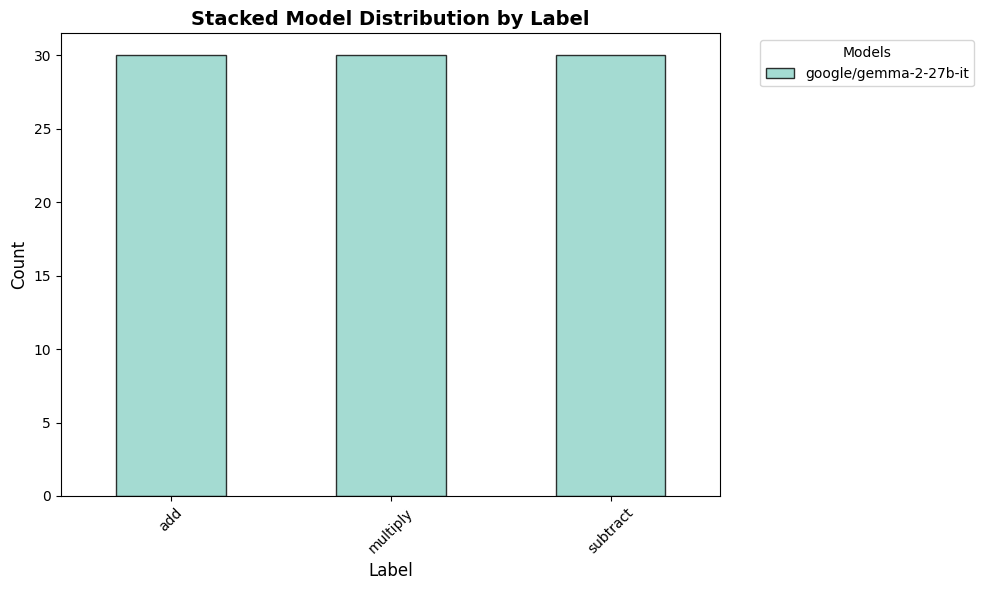

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

def plot_model_counts_by_label(
    df: pd.DataFrame,
    label_col: str = 'label',
    model_col: str = 'model',
    figsize: tuple = (12, 8),
    title: str = None,
    color_palette: str = 'Set2',
    save_path: str = None
):
    """
    Create a grouped histogram showing model counts for each label category.

    Args:
        df (pd.DataFrame): DataFrame containing the data
        label_col (str): Column name for labels/categories
        model_col (str): Column name for models
        figsize (tuple): Figure size (width, height)
        title (str): Plot title (auto-generated if None)
        color_palette (str): Color palette for bars
        save_path (str): Path to save the plot (optional)

    Returns:
        tuple: (fig, ax) matplotlib objects
    """

    # Get unique labels and models
    unique_labels = sorted(df[label_col].unique())
    unique_models = sorted(df[model_col].unique())

    # Create count matrix
    count_data = []
    for label in unique_labels:
        label_data = df[df[label_col] == label]
        counts = label_data[model_col].value_counts()
        label_counts = [counts.get(model, 0) for model in unique_models]
        count_data.append(label_counts)

    # Convert to numpy array for easier manipulation
    count_matrix = np.array(count_data)

    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Set width of bars and positions
    bar_width = 0.8 / len(unique_models)
    positions = np.arange(len(unique_labels))

    # Colors
    colors = sns.color_palette(color_palette, len(unique_models))

    # Create bars for each model
    for i, model in enumerate(unique_models):
        model_counts = count_matrix[:, i]
        bar_positions = positions + (i - len(unique_models)/2 + 0.5) * bar_width

        bars = ax.bar(
            bar_positions,
            model_counts,
            bar_width,
            label=model,
            color=colors[i],
            alpha=0.8,
            edgecolor='black',
            linewidth=0.5
        )

        # Add value labels on bars
        for bar, count in zip(bars, model_counts):
            if count > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.1,
                    str(int(count)),
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    fontweight='bold'
                )

    # Customize the plot
    ax.set_xlabel('Label Categories', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax.set_title(title or f'Model Distribution Across {label_col.title()} Categories',
                 fontsize=14, fontweight='bold', pad=20)

    # Set x-axis
    ax.set_xticks(positions)
    ax.set_xticklabels(unique_labels, rotation=45 if len(max(unique_labels, key=len)) > 8 else 0)

    # Add legend
    ax.legend(title='Models', loc='upper right', frameon=True, fancybox=True, shadow=True)

    # Add grid for better readability
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

    # Adjust layout
    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    return fig, ax

def plot_model_counts_advanced(
    df: pd.DataFrame,
    label_col: str = 'label',
    model_col: str = 'model',
    figsize: tuple = (15, 10),
    style: str = 'grouped'  # 'grouped', 'stacked', or 'side_by_side'
):
    """
    Advanced plotting function with multiple visualization styles.

    Args:
        df: DataFrame with data
        label_col: Column name for labels
        model_col: Column name for models
        figsize: Figure size
        style: Plotting style ('grouped', 'stacked', 'side_by_side')

    Returns:
        matplotlib figure and axes
    """

    # Create crosstab for easier manipulation
    crosstab = pd.crosstab(df[label_col], df[model_col])

    if style == 'grouped':
        return plot_model_counts_by_label(df, label_col, model_col, figsize)

    elif style == 'stacked':
        fig, ax = plt.subplots(figsize=figsize)
        crosstab.plot(kind='bar', stacked=True, ax=ax,
                     colormap='Set3', alpha=0.8, edgecolor='black')
        ax.set_title(f'Stacked Model Distribution by {label_col.title()}',
                    fontsize=14, fontweight='bold')
        ax.set_xlabel(label_col.title(), fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()

    elif style == 'side_by_side':
        fig, axes = plt.subplots(1, len(crosstab.index), figsize=figsize, sharey=True)
        if len(crosstab.index) == 1:
            axes = [axes]

        for i, (label, row) in enumerate(crosstab.iterrows()):
            row.plot(kind='bar', ax=axes[i], color=sns.color_palette('Set2', len(row)))
            axes[i].set_title(f'{label}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Models', fontsize=10)
            if i == 0:
                axes[i].set_ylabel('Count', fontsize=10)
            axes[i].tick_params(axis='x', rotation=45)

        plt.suptitle(f'Model Distribution by {label_col.title()} (Side by Side)',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()

    return fig, axes if 'axes' in locals() else ax

def create_summary_table(df: pd.DataFrame, label_col: str = 'label', model_col: str = 'model'):
    """
    Create a summary table showing the distribution.

    Args:
        df: DataFrame with data
        label_col: Column name for labels
        model_col: Column name for models

    Returns:
        pd.DataFrame: Summary table with counts and percentages
    """

    # Create crosstab
    crosstab = pd.crosstab(df[label_col], df[model_col], margins=True)

    # Calculate percentages
    crosstab_pct = pd.crosstab(df[label_col], df[model_col], normalize='index') * 100

    print("Count Distribution:")
    print(crosstab)
    print("\nPercentage Distribution (by row):")
    print(crosstab_pct.round(2))

    return crosstab, crosstab_pct




df = test
df["model"] = models
print("Sample Data:")
print(df.head(10))
print(f"\nDataFrame shape: {df.shape}")

# Create summary table
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)
create_summary_table(df)

# Plot with different styles
print(f"\n{'='*50}")
print("CREATING PLOTS")
print("="*50)

# # Grouped histogram
# fig1, ax1 = plot_model_counts_by_label(df, figsize=(12, 8))
# plt.show()

# Stacked version
fig2, ax2 = plot_model_counts_advanced(df, style='stacked', figsize=(10, 6))
plt.show()

# # Side by side version
# fig3, ax3 = plot_model_counts_advanced(df, style='side_by_side', figsize=(15, 5))
# plt.show()



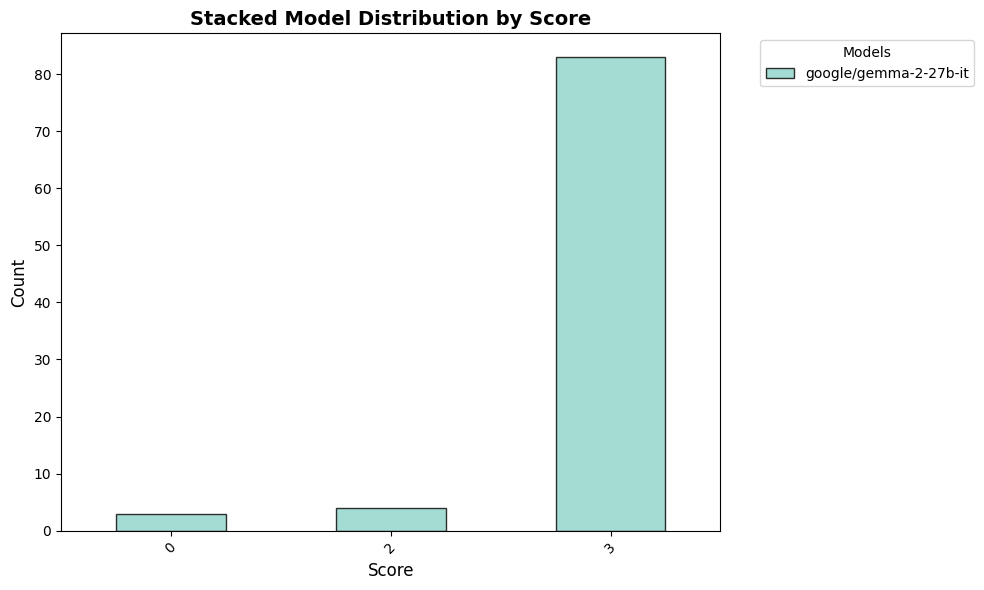

In [ ]:
scores = pd.DataFrame()
scores["score"] = [eval_responses[i].score for i, val in enumerate(eval_responses)]
scores["model"] = models
fig2, ax2 = plot_model_counts_advanced(scores, style='stacked', figsize=(10, 6), label_col="score", model_col="model")
plt.show()